# Reverse inference - Example without using ontologies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

In [2]:
nl = fe.NeurolangDL()
datasets_helper.load_reverse_inference_dataset_deterministic(nl)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use 

In [3]:
@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

### Testing julich atlas

In [4]:
with nl.scope as e:
    
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [5]:
def create_region(x, y, z, img):
    voxels = nib.affines.apply_affine(
        np.linalg.inv(img.affine), np.c_[x, y, z]
    )
    return fe.ExplicitVBR(voxels, img.affine, image_dim=img.shape)

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 4.0
  return self.volume.get_header()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:624: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  old_data = self.data.to_dense()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:634: FutureWarning: DataFrame.to_sparse is deprecated and will be removed in a future version
  self.data = data.fillna(0.0).to_sparse()
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:3451: FutureWarning: SparseSeries is deprecated and will be removed in a future version.
Use 

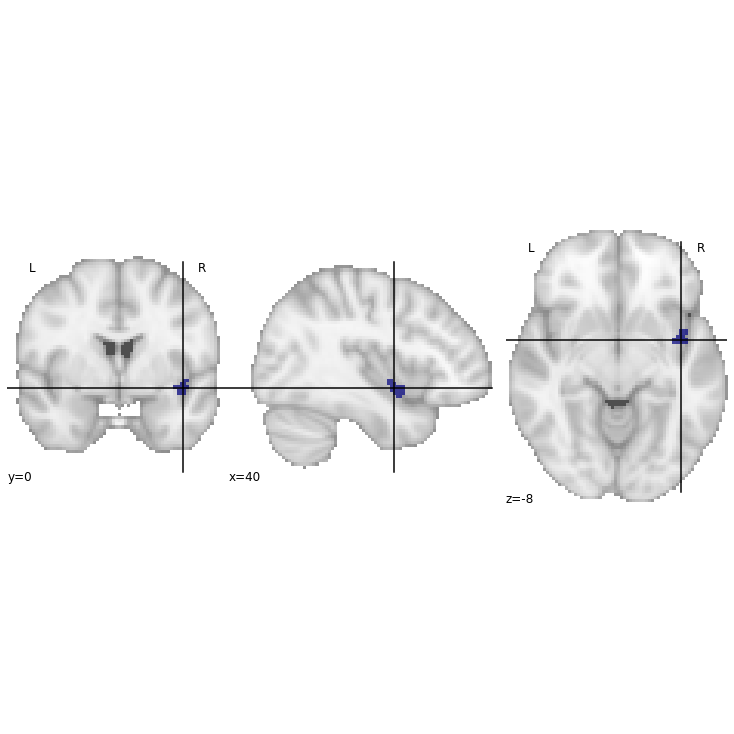

In [6]:
from neurolang.regions import region_union
import nibabel as nib
from nilearn import image

results = nl_results['julich_voxels'].unwrapped_iter()

nsh = fe.neurosynth_utils.NeuroSynthHandler()
ns_ds = nsh.ns_load_dataset()
it = ns_ds.image_table

regions = []
vox_prob = []

atlas_r_filename = './22/MPM/JulichBrain_MPMAtlas_r_N10_nlin2Stdicbm152asym2009c_publicDOI_14622b49a715338ce96e96611d395646.nii.gz'
img_r = image.load_img(atlas_r_filename)
julich_to_ns_mni = image.resample_to_img(
    img_r, it.masker.volume, interpolation="nearest"
)

for id_, x, y, z in results:
    r_overlay = create_region(x, y, z, julich_to_ns_mni)
    vox_prob.append((r_overlay.voxels, 1))
    regions.append(r_overlay)

regions = region_union(regions)

prob_img = nib.spatialimages.SpatialImage(
    np.zeros(regions.image_dim, dtype=float), affine=regions.affine
)
for v, p in vox_prob:
    prob_img.dataobj[tuple(v.T)] = p

#plotting.plot_stat_map(
#    prob_img, 
    #title='Tag "auditory" (Neurolang)', 
    #bg_img='/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/resources/MNI152_T1_2mm_brain.nii.gz',
#    cmap='PuBuGn',
#    display_mode='x',
#    cut_coords=np.linspace(-63, 63, 4),
#)


import matplotlib.pyplot as plt
fg = plt.figure(figsize=(10, 10))
plotting.plot_roi(prob_img, figure=fg)


### Example

In [8]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [9]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');


In [10]:
with nl.scope as e:
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [11]:
c = nl_results['e_term_given_aud_act']._container.copy()

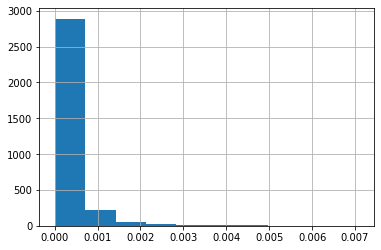

In [12]:
c[1].hist();

In [13]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
1689,magnetic,0.007094
2501,resonance,0.007079
1690,magnetic resonance,0.007031
1214,functional magnetic,0.006441
3078,using,0.005914
1314,healthy,0.005744
194,anterior,0.005659
1492,insula,0.005172
420,cingulate,0.004935
2917,task,0.004742


In [29]:
tt = c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)
tt.rename(columns={0: 'term', 1: 'prob'}, inplace=True)
tt.head(15)

,term,prob
1689,magnetic,0.007094
2501,resonance,0.007079
1690,magnetic resonance,0.007031
1214,functional magnetic,0.006441
3078,using,0.005914
1314,healthy,0.005744
194,anterior,0.005659
1492,insula,0.005172
420,cingulate,0.004935
2917,task,0.004742


# Reverse inference - Example using ontologies

In [1]:
import warnings
warnings.filterwarnings('ignore')

import stats_helper, datasets_helper
from neurolang.frontend.probabilistic_frontend import ProbabilisticFrontend
from rdflib import RDFS, RDF
from nilearn import plotting
import numpy as np
from matplotlib import pyplot as plt
from typing import Iterable
from neurolang import frontend as fe

nl = fe.probabilistic_frontend.ProbabilisticFrontend()

datasets_helper.load_reverse_inference_dataset_deterministic(nl)

paths = 'neurolang_data/ontologies/cogat.xrdf'
nl.load_ontology(paths)


@nl.add_symbol
def agg_count(x: Iterable) -> int:
    return len(x)

@nl.add_symbol
def agg_sum(x: Iterable) -> float:
    return x.sum()

@nl.add_symbol
def agg_mean(x: Iterable) -> float:
    return x.mean()

@nl.add_symbol
def first_word(name: str) -> str:
    return name.split(" ")[0].lower()

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/nilearn/plotting/cm.py:159: MatplotlibDeprecationWarning: 
The revcmap function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use Colormap.reversed() instead.
  _cmaps_data[_cmapname_r] = _cm.revcmap(_cmapspec)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 fro

In [2]:
part_of = nl.new_symbol(name='http://www.obofoundry.org/ro/ro.owl#part_of')
subclass_of = nl.new_symbol(name=str(RDFS.subClassOf))
label = nl.new_symbol(name=str(RDFS.label))

In [3]:
#triples = nl.symbol_table[nl.get_ontology_triples_symbol().name]
#a = triples.value.as_numpy_array()
#t = [('Auditory', str(RDF.type), 'http://www.cognitiveatlas.org/ontology/cogat.owl#CAO_00148')]

#t = np.concatenate((a, t))
#nl.add_extensional_predicate_from_tuples(t, name=nl.get_ontology_triples_symbol().name)

In [4]:
with nl.scope as e:
    e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z] = (
        e.xyz_julich[e.x, e.y, e.z, e.julich_id] &
        e.xyz_neurosynth[e.x, e.y, e.z, e.id_neurosynth]
    )
    
    e.region_voxels[e.name, e.id_neurosynth, e.x, e.y, e.z] = (
        e.julich_id[e.name, e.julich_id] &
        e.julich_to_neurosynth[e.julich_id, e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.julich_id[e.name, e.id] = (
        e.julich_ontology[e.name, 'labelIndex', e.id]
    )
    
    #e.julich_id[e.name, e.id] = (
    #    e.julich_ontology[e.name, 'subClassOf', e.son_name] &
    #    e.julich_id[e.son_name, e.id]
    #)
    
    e.julich_voxels[e.id_neurosynth, e.x, e.y, e.z] = (
        e.region_voxels['Area Ia (Insula)', e.id_neurosynth, e.x, e.y, e.z]
    )
    
    e.term_docs[e.term, e.pmid] = (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        (e.tfidf > 1e-3)        
    )

    e.term_counts[e.term, agg_count(e.pmid)] =  (
        e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf] &
        e.term_docs[e.term, e.pmid]
    )
    
    e.act_counts[e.voxid, agg_count(e.pmid)] = e.ns_activations_by_id[e.pmid, e.voxid]
    
    e.quantity_docs[agg_count(e.pmid)] = e.ns_pmid_term_tfidf[e.pmid, e.term, e.tfidf]
    
    e.act_prob[e.voxid, e.prob] = (
        e.act_counts[e.voxid, e.count] &
        e.quantity_docs[e.q] &
        (e.prob == e.count / e.q)
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [5]:
t = nl_results['julich_voxels'].as_numpy_array()
f = [(int(voxid), x, y, z) for voxid, x, y, z in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='julich_voxels');

t = nl_results['term_docs'].as_numpy_array()
f = [(term, pmid) for term, pmid in t]
term_docs = nl.add_tuple_set(tuple(f), name='term_docs');

t = nl_results['act_counts'].as_numpy_array()
f = [(int(voxid), count) for voxid, count in t]
act_counts = nl.add_tuple_set(tuple(f), name='act_counts');

t = nl_results['act_prob'].as_numpy_array()
f = [(int(voxid), p) for voxid, p in t]
act_prob = nl.add_tuple_set(tuple(f), name='act_prob');

In [6]:
from neurolang.expressions import Constant, Symbol

@nl.add_symbol
def words(x: Iterable) -> str:
    b = ''
    for a in x:
        b = b + a + ' '
        
    b = set(b.lower().split(' '))
    
    return " ".join(b)

@nl.add_symbol
def word_lower(name: str) -> str:
    print(name)
    return str(name).lower()

@nl.add_symbol
def is_in(x: str, l: str) -> bool:
    b = l.split(' ')
    if x in b:
        return True
    
    return False

In [7]:
hasTopConcept = nl.new_symbol(name='http://www.w3.org/2004/02/skos/core#hasTopConcept')
with nl.scope as e:
    #e.pre_part[e.x, e.y] = part_of[e.x, e.y]

    #e.ontology_terms[e.term] = (
    #    e.pre_part["Auditory", e.y] & subclass_of[e.z, e.y] & label(e.z, e.n) &
    #    (e.term == nl.symbols.first_word(e.n))
    #)
    
    #e.ontology_terms[e.words(e.name)] = (
    #    hasTopConcept[e.uri, 'Executive-Cognitive Control'] &
    #    label[e.uri, e.name]
    #)
    
    e.ontology_terms[e.name] = (
        hasTopConcept[e.uri, 'Executive-Cognitive Control'] &
        label[e.uri, e.name]
    )
    
    e.act_term_counts[e.voxid, e.term, agg_count(e.pmid)] = (
        julich_voxels[e.voxid, e.x, e.y, e.z] &
        term_docs[e.term, e.pmid] &
        e.ns_activations_by_id[e.pmid, e.voxid]
    )

    e.p_term_given_act[e.term, e.voxid, e.prob] = (
        e.act_term_counts[e.voxid, e.term, e.act_term_count] &
        act_counts[e.voxid, e.act_count] &
        (e.prob == e.act_term_count / e.act_count)
    )
    
    e.e_term_given_aud_act[e.term, agg_sum(e.p)] = (
        e.p_term_given_act[e.term, e.voxid, e.prob] & 
        act_prob[e.voxid, e.act_prob_] &
        (e.p == e.prob * e.act_prob_)    
    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.

In [10]:
t = nl_results['ontology_terms'].as_numpy_array()
f = [tuple(term)[0].lower() for term in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='ontology_terms');

t = nl_results['e_term_given_aud_act'].as_numpy_array()
f = [(term, p) for term, p in t]
julich_voxels = nl.add_tuple_set(tuple(f), name='reverse_inference');

In [11]:

with nl.scope as e:
    e.filtered_terms[e.term, e.p] = (
        e.reverse_inference[e.term, e.p] &
        e.ontology_terms[e.term]
    )
    
    

#with nl.scope as e:
#    e.filtered_terms[e.term, e.p] = (
#        e.ontology_terms[e.t] & 
#        e.reverse_inference[e.term, e.p] &
#        is_in[e.term, e.t]
#    )
    
    nl_results = nl.solve_all()

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:152: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


In [12]:
nl_results['filtered_terms']

                     0         1
0    cognitive control  0.000409
1                 goal  0.000629
2           inhibition  0.000605
3          maintenance  0.000281
4         manipulation  0.000260
5           monitoring  0.000537
6             planning  0.000244
7  response inhibition  0.000181
8             updating  0.000116
9       working memory  0.000654

In [13]:
c = nl_results['filtered_terms']._container.copy()
tt = c.sort_values(1, ascending=False)
tt.rename(columns={0: 'term', 1: 'prob'}, inplace=True)
tt.head(15)

,term,prob
9,working memory,0.000654
1,goal,0.000629
2,inhibition,0.000605
5,monitoring,0.000537
0,cognitive control,0.000409
3,maintenance,0.000281
4,manipulation,0.000260
6,planning,0.000244
7,response inhibition,0.000181
8,updating,0.000116


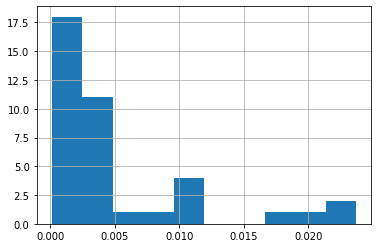

In [168]:
c[1].hist();

In [169]:
c[c[1] >= c[1].quantile(.99)].sort_values(1, ascending=False)

,0,1
2917,task,0.023711


In [40]:
import rdflib

g = rdflib.Graph()
g.load('neurolang_data/ontologies/cogat.xrdf')

In [147]:
control = g.triples((None, rdflib.term.URIRef('http://www.w3.org/2004/02/skos/core#hasTopConcept'), rdflib.term.Literal('Executive-Cognitive Control')))
for a, b, c in control:
    n = list(g.triples((a, rdflib.term.URIRef('http://www.w3.org/2000/01/rdf-schema#label'), None)))
    print(n[0][2])

Behavioral inhibition (cognitive)
Proactive control
Goal maintenance
Top down processing
Working memory retrieval
Chunking
Selective control
Response inhibition
Goal management
Working memory
Working memory storage
Performance monitoring
Semantic working memory
Updating
Set shifting
Interference resolution
Task set
Goal state
Inhibition
Planning
Resource limit
Task switching
Maintenance
Central executive
Response conflict
Cognitive control
Metamemory
Resistance to distractor inference
Goal
Self monitoring
Manipulation
Error detection
Goal formation
Supervisory attentional system
Working memory maintenance
Self control
Active maintenance
Cognitive load
Phonological working memory
Visuospatial sketch pad
Monitoring
Inhibition of return
